# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.



---

**Q1**

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/sya?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page



---



## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [31]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [32]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})



---

**Q2**

In [36]:
from bs4 import BeautifulSoup

bsObj = BeautifulSoup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

# print(bsObj)
print(listings)

[<li class="cl-static-search-result" title="Laptop Stands / DJ Stands / Music Stands">
<a href="https://charlottesville.craigslist.org/sys/d/charlottesville-laptop-stands-dj-stands/7786403500.html">
<div class="title">Laptop Stands / DJ Stands / Music Stands</div>
<div class="details">
<div class="price">$40</div>
<div class="location">
                        Charlottesville
                    </div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="Dell Inspiron 3655 AMD A8-7410 Tower Only">
<a href="https://charlottesville.craigslist.org/sys/d/fredericksburg-dell-inspiron-3655-amd/7782947147.html">
<div class="title">Dell Inspiron 3655 AMD A8-7410 Tower Only</div>
<div class="details">
<div class="price">$75</div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="USB Keyboards">
<a href="https://charlottesville.craigslist.org/sys/d/charlottesville-usb-keyboards/7785989041.html">
<div class="title">USB Keyboards</div>
<div class="details">
<div class="price">

In [37]:
import re # Regular expressions

brands = ['apple', 'playstation', 'dell', 'lenovo', 'asus', 'samsung', 'canon',
          'targus', 'abs', 'jonsbo', 'ryzen', 'antect', 'montech', 'thermaltake',
          'mustex']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

for d in data:
  print(d)

{'title': 'laptop stands / dj stands / music stands', 'price': '$40', 'year': nan, 'link': 'https://charlottesville.craigslist.org/sys/d/charlottesville-laptop-stands-dj-stands/7786403500.html', 'brand': 'missing'}
{'title': 'dell inspiron 3655 amd a8-7410 tower only', 'price': '$75', 'year': nan, 'link': 'https://charlottesville.craigslist.org/sys/d/fredericksburg-dell-inspiron-3655-amd/7782947147.html', 'brand': 'dell'}
{'title': 'usb keyboards', 'price': '$15', 'year': nan, 'link': 'https://charlottesville.craigslist.org/sys/d/charlottesville-usb-keyboards/7785989041.html', 'brand': 'missing'}
{'title': 'targus 16 inch n2953 laptop dual fan cooling pad', 'price': '$20', 'year': nan, 'link': 'https://charlottesville.craigslist.org/sys/d/charlottesville-targus-16-inch-n2953/7785984100.html', 'brand': 'targus'}
{'title': '2 computers', 'price': '$90', 'year': nan, 'link': 'https://charlottesville.craigslist.org/sys/d/quinque-computers/7782312652.html', 'brand': 'missing'}
{'title': 'ga



---



## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [33]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(96, 6)


,title,price,year,link,brand,age
0,1999 dodge ram 4x4,3100,1999.0,https://charlottesville.craigslist.org/cto/d/b...,dodge,26.0
1,used 2009 hyundai santa fe,3000,2009.0,https://charlottesville.craigslist.org/cto/d/c...,missing,16.0
2,2006 mercedes-benz slk280 2dr convertible,6999,2006.0,https://charlottesville.craigslist.org/cto/d/m...,missing,19.0
3,2007 volvo xc70 awd 182k,4300,2007.0,https://charlottesville.craigslist.org/cto/d/c...,volvo,18.0
4,2013 toyota yaris hatchback,3500,2013.0,https://charlottesville.craigslist.org/cto/d/c...,toyota,12.0


With the data in and wrangled, we can now do EDA:

count       96.000000
mean      7532.010417
std       7685.275846
min         10.000000
25%       3000.000000
50%       4950.000000
75%       9612.500000
max      49900.000000
Name: price, dtype: float64


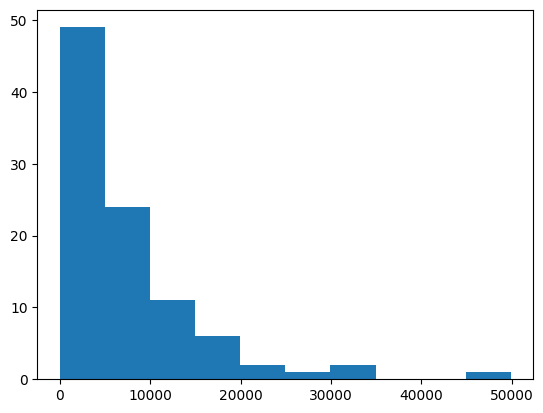

count    76.000000
mean     19.144737
std      10.326282
min       4.000000
25%      13.000000
50%      18.000000
75%      22.000000
max      63.000000
Name: age, dtype: float64


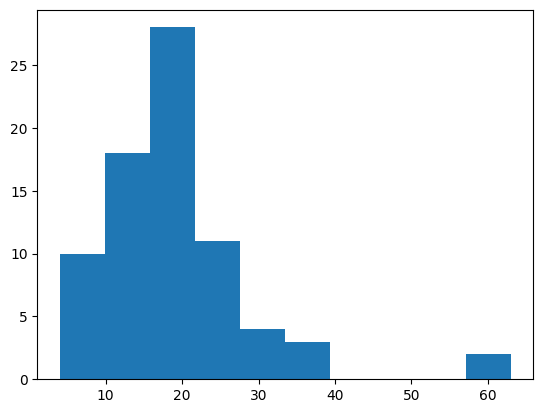

In [34]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
acura        1.0   3500.000000           NaN   3500.0   3500.00   3500.0   
audi         2.0   6432.500000   7399.872465   1200.0   3816.25   6432.5   
bmw          4.0   6875.000000   3065.262360   3000.0   5250.00   7250.0   
buick        1.0   4500.000000           NaN   4500.0   4500.00   4500.0   
chevrolet    4.0   8750.000000   5866.571969   5000.0   5750.00   6250.0   
chevy        3.0   2670.000000   2303.627574     10.0   2005.00   4000.0   
dodge        5.0   7100.000000   3435.112807   2000.0   6000.00   7000.0   
ford        11.0   7722.272727   6643.448413   1000.0   1750.00   7250.0   
gmc          4.0   5787.500000   2365.859604   3500.0   4250.00   5375.0   
honda       11.0   7040.818182   3732.055381   1000.0   5000.00   5900.0   
jeep         6.0   8249.166667   6926.074225   1500.0   2750.00   6997.5   
kia          2.0   6500.000000   4242.640687   3500.0   5000.00   6500.0   
missing     26.0  11151.884615  10189.403729   1200.0   3000.00   7000.0   
mitsubishi   1.0   3500.000000           NaN   3500.0   3500.00   3500.0   
subaru       4.0   8875.000000   9844.922549   2500.0   3400.00   4750.0   
tesla        2.0  21450.000000   6434.671709  16900.0  19175.00  21450.0   
toyota       7.0  14107.142857  14253.433170   3300.0   4100.00   7500.0   
volkswagen   1.0   4950.000000           NaN   4950.0   4950.00   4950.0   
volvo        2.0   2050.000000     70.710678   2000.0   2025.00   2050.0   

                               
                 75%      max  
brand                          
acura        3500.00   3500.0  
audi         9048.75  11665.0  
bmw          8875.00  10000.0  
buick        4500.00   4500.0  
chevrolet    9250.00  17500.0  
chevy        4000.00   4000.0  
dodge       10000.00  10500.0  
ford        11200.00  18995.0  
gmc          6912.50   8900.0  
honda        9325.00  13000.0  
jeep        11998.75  19000.0  
kia          8000.00   9500.0  
missing     16875.00  35000.0  
mitsubishi   3500.00   3500.0  
subaru      10225.00  23500.0  
tesla       23725.00  26000.0  
toyota      20875.00  38000.0  
volkswagen   4950.00   4950.0  
volvo        2075.00   2100.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                  
           count   mean        std   min    25%   50%    75%   max
brand                                                             
acura        1.0  17.00        NaN  17.0  17.00  17.0  17.00  17.0
audi         1.0  21.00        NaN  21.0  21.00  21.0  21.00  21.0
bmw          2.0  12.50   2.121320  11.0  11.75  12.5  13.25  14.0
buick        0.0    NaN        NaN   NaN    NaN   NaN    NaN   NaN
chevrolet    4.0  29.50   8.962886  17.0  26.00  32.5  36.00  36.0
chevy        2.0  27.00   5.656854  23.0  25.00  27.0  29.00  31.0
dodge        2.0  36.00  21.213203  21.0  28.50  36.0  43.50  51.0
ford        10.0  23.50  17.494444   8.0  14.00  18.0  23.00  67.0
gmc          4.0  19.50   7.325754  10.0  16.00  20.5  24.00  27.0
honda       11.0  17.00   6.811755  10.0  11.50  17.0  20.00  33.0
jeep         5.0  29.00  20.211383   9.0  22.00  24.0  27.00  63.0
kia          2.0  12.50   4.949747   9.0  10.75  12.5  14.25  16.0
missing     20.0  22.15  16.556999   6.0  13.50  17.5  24.50  62.0
mitsubishi   1.0  19.00        NaN  19.0  19.00  19.0  19.00  19.0
subaru       4.0  15.00   5.354126   7.0  14.50  17.5  18.00  18.0
tesla        2.0   8.00   1.414214   7.0   7.50   8.0   8.50   9.0
toyota       6.0  12.50   7.395945   4.0   7.00  12.0  17.75  22.0
volkswagen   1.0  15.00        NaN  15.0  15.00  15.0  15.00  15.0
volvo        2.0  27.00   8.485281  21.0  24.00  27.0  30.00  33.0

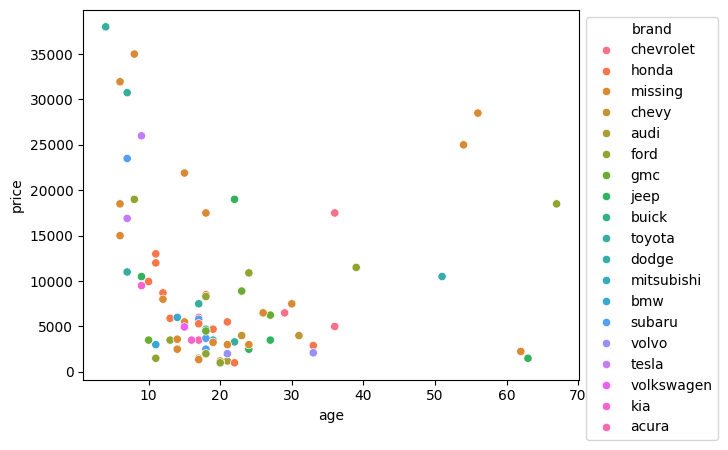

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   1.198483 -0.178625
log_age    -0.178625  0.344903
           log_price   log_age
log_price   1.000000 -0.326115
log_age    -0.326115  1.000000


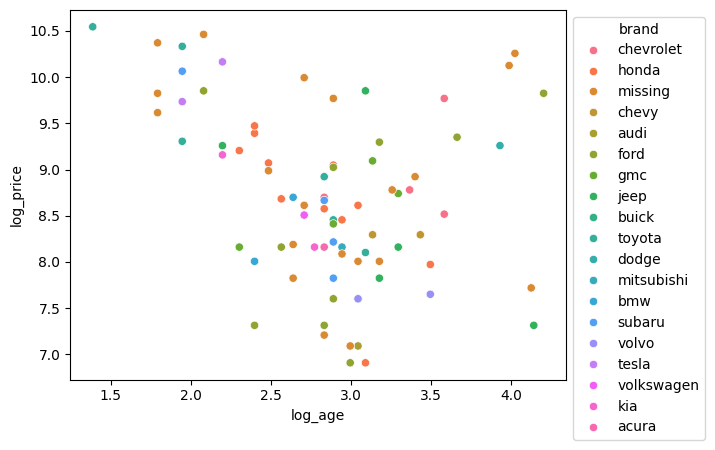

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

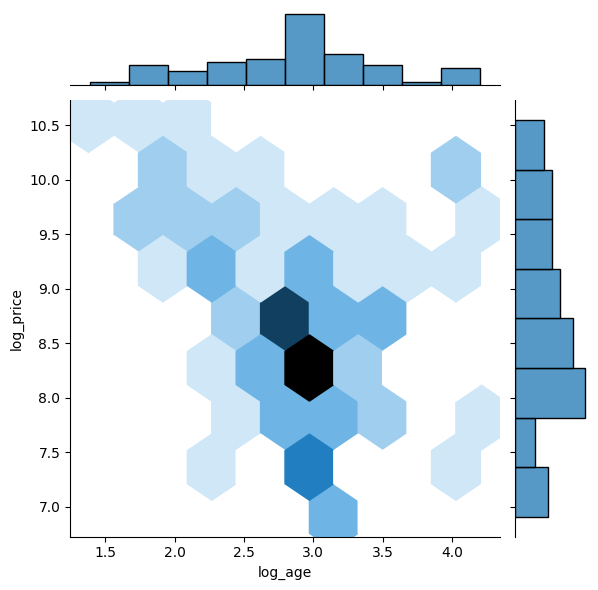

In [ ]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')



---

**Q3**

In [43]:
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_computers.csv') # Save data in case of a disaster
df.head()

(40, 6)


,title,price,year,link,brand,age
0,laptop stands / dj stands / music stands,40,NaN,https://charlottesville.craigslist.org/sys/d/c...,missing,NaN
1,dell inspiron 3655 amd a8-7410 tower only,75,NaN,https://charlottesville.craigslist.org/sys/d/f...,dell,NaN
2,usb keyboards,15,NaN,https://charlottesville.craigslist.org/sys/d/c...,missing,NaN
3,targus 16 inch n2953 laptop dual fan cooling pad,20,NaN,https://charlottesville.craigslist.org/sys/d/c...,targus,NaN
4,2 computers,90,NaN,https://charlottesville.craigslist.org/sys/d/q...,missing,NaN


count      40.000000
mean      593.225000
std       571.195664
min         0.000000
25%        68.750000
50%       524.500000
75%      1006.250000
max      1900.000000
Name: price, dtype: float64


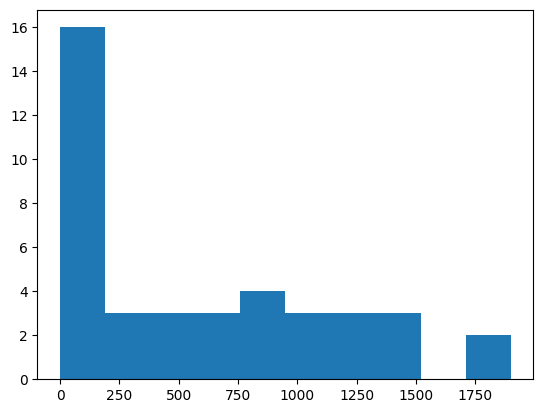

In [44]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

In [45]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                              \
            count         mean          std     min      25%     50%      75%   
brand                                                                           
abs           1.0  1900.000000          NaN  1900.0  1900.00  1900.0  1900.00   
antect        2.0   550.000000     0.000000   550.0   550.00   550.0   550.00   
apple         2.0   325.000000   388.908730    50.0   187.50   325.0   462.50   
asus          2.0   787.500000  1007.627163    75.0   431.25   787.5  1143.75   
canon         3.0     8.333333    14.433757     0.0     0.00     0.0    12.50   
dell          5.0   494.800000   587.471446    75.0   100.00   300.0   499.00   
jonsbo        1.0   750.000000          NaN   750.0   750.00   750.0   750.00   
lenovo        1.0   275.000000          NaN   275.0   275.00   275.0   275.00   
missing      12.0   417.500000   470.480895    10.0    37.50    95.0   825.00   
montech       1.0   900.000000          NaN   900.0   900.00   900.0   900.00   
mustex        1.0  1800.000000          NaN  1800.0  1800.00  1800.0  1800.00   
playstation   1.0   150.000000          NaN   150.0   150.00   150.0   150.00   
ryzen         4.0  1200.000000   216.024690  1000.0  1075.00  1150.0  1275.00   
samsung       1.0   250.000000          NaN   250.0   250.00   250.0   250.00   
targus        1.0    20.000000          NaN    20.0    20.00    20.0    20.00   
thermaltake   2.0  1025.000000   247.487373   850.0   937.50  1025.0  1112.50   

                     
                max  
brand                
abs          1900.0  
antect        550.0  
apple         600.0  
asus         1500.0  
canon          25.0  
dell         1500.0  
jonsbo        750.0  
lenovo        275.0  
missing      1200.0  
montech       900.0  
mustex       1800.0  
playstation   150.0  
ryzen        1500.0  
samsung       250.0  
targus         20.0  
thermaltake  1200.0

<Figure size 1200x600 with 0 Axes>

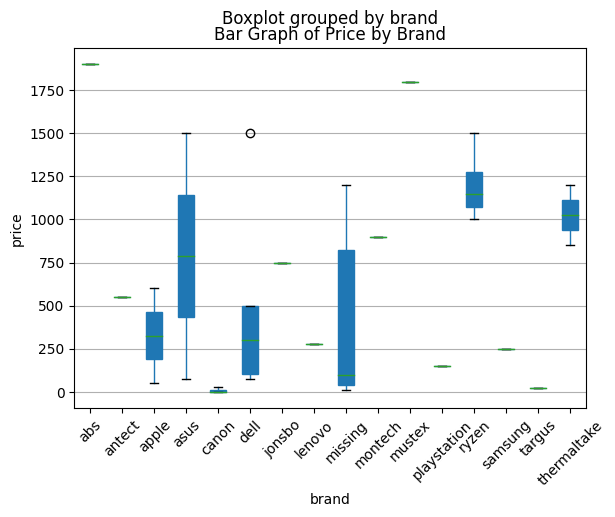

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))
df.boxplot(column='price', by='brand', grid=False, patch_artist=True)
plt.xlabel('brand')
plt.ylabel('price')
plt.title('Bar Graph of Price by Brand')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



---



## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

In [ ]:
import time # Time delays
import random # Random numbers

links = df['link']
data = []
for link in links: # about 3 minutes
    time.sleep(random.randint(1, 3)) # Random delays
    raw = requests.get(link,headers=header) # Get page
    bsObj = soup(raw.content,'html.parser') # Parse the html
    #
    try:
        year_post = bsObj.find(class_='attr important').find(class_ = 'valu year').get_text()
    except:
        year_post = np.nan
    #
    try:
        condition = bsObj.find(class_='attr condition').find(href=True).get_text()
    except:
        condition = 'missing'
    #
    try:
        cylinders = bsObj.find(class_='attr auto_cylinders').find(class_ = 'valu').get_text()
        cylinders = cylinders.replace('\n','')
    except:
        cylinders = 'missing'
    #
    try:
        drivetrain = bsObj.find(class_='attr auto_drivetrain').find(href=True).get_text()
    except:
        drivetrain = 'missing'
    #
    try:
        fuel = bsObj.find(class_='attr auto_fuel_type').find(href = True).get_text()
    except:
        fuel = 'missing'
    #
    try:
        miles = bsObj.find(class_='attr auto_miles').find(class_ = 'valu').get_text()
    except:
        miles = np.nan
    #
    try:
        color = bsObj.find(class_='attr auto_paint').find(href=True).get_text()
    except:
        color='missing'
    #
    try:
        title = bsObj.find(class_='attr auto_title_status').find(href=True).get_text()
    except:
        title='missing'
    #
    try:
        transmission = bsObj.find(class_='attr auto_transmission').find(href=True).get_text()
    except:
        transmission = 'missing'
    #
    try:
        bodytype = bsObj.find(class_='attr auto_bodytype').find(href=True).get_text()
    except:
        bodytype = 'missing'
    #
    text = bsObj.find(id='postingbody').get_text()
    text = text.replace('\n','')
    text = text.replace('QR Code Link to This Post','')
    record = {'title':title,
              'year_post':year_post,
              'condition':condition,
              'cylinders':cylinders,
              'drivetrain':drivetrain,
              'fuel':fuel,
              'miles':miles,
              'color':color,
              'title':'title',
              'transmission':transmission,
              'bodytype':bodytype,
              'text':text,}
    data.append(record)

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

In [ ]:
new_df = pd.DataFrame.from_dict(data)
new_df.head()

df = pd.concat([df,new_df],axis=1) # combine data frames
df.head()

df['miles'] = df['miles'].str.replace(',','')
df['miles'] = pd.to_numeric(df['miles'],errors='coerce')

df['year_post'] = df['year_post'].str.replace(',','')
df['year_post'] = pd.to_numeric(df['year_post'],errors='coerce')
df.to_csv('craiglist_cville_cars_long.csv')